In [1]:
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.tsa.stattools import adfuller, kpss
import numpy as np
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
from tensorflow import keras
%matplotlib inline
from tensorflow import keras
import tensorflow as tf
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer._decayed_lr(tf.float32) # I use ._decayed_lr method instead of .lr
    return lr

In [2]:
df = pd.read_csv('/Users/parthverma/DS-D590/djangoProject/data/txns.csv',index_col=['INSERTION_DATE'], parse_dates=['INSERTION_DATE'], date_parser=pd.to_datetime)

/var/folders/b9/rnrdyjdx0bv964x46pqpkvs00000gn/T/ipykernel_18568/997255710.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/parthverma/DS-D590/djangoProject/data/txns.csv',index_col=['INSERTION_DATE'], parse_dates=['INSERTION_DATE'], date_parser=pd.to_datetime)


In [3]:
df['TOTAL_AMOUNT'] = df['TOTAL_AMOUNT'].fillna(0).astype(float)
df['PG_TDR_SC'] = df['PG_TDR_SC'].fillna(0).astype(float)
df = df.dropna(axis=0, subset=['PAY_ID'])
df['PAY_ID'] = df['PAY_ID'].astype(int).astype(str)
pay_id = list(df['PAY_ID'].unique())
succesful_txns = df[(df['STATUS'] == 'Captured') | (df['STATUS'] == 'Settled')]

# Number of transaction model

In [4]:
def split_sequence(sequence, n_steps):
  X, y = list(), list()
  for i in range(len(sequence)):
  # find the end of this pattern
    end_ix = i + n_steps
  # check if we are beyond the sequence
    if end_ix > len(sequence)-1:
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
    X.append(seq_x)
    y.append(seq_y)
  X = np.array(X)
  return X.reshape((X.shape[0], X.shape[1], 1)), np.array(y)

In [5]:
def train_test_split(df):
    
    train = df[:df.last_valid_index()-pd.DateOffset(60, 'D')]
    test = df[df.last_valid_index()-pd.DateOffset(60, 'D'):]
    return train,test

In [ ]:
n_steps_choices = [5,7,14,30]


for i in pay_id:
    dataset = df[df['PAY_ID'] == i]['TOTAL_AMOUNT'].resample('1D').count()
    if len(dataset) == 1:
        continue
#     transformed, lmbd = boxcox(dataset+1e-6)
#     transformed = pd.DataFrame(data=transformed, 
#                                index=dataset.index)
    
#     diffs = 0 
#     while True:
#         result = kpss(np.diff(np.array(transformed).reshape(-1),n=diffs))
#         if all(map(lambda x: x> result[0], result[3].values())):
#             break
#         diffs+=1
#     transformed = np.diff(np.array(transformed).reshape(-1),n=diffs)
#     transformed = pd.Series(transformed,index=dataset.index[diffs:])
    train,test = train_test_split(dataset)
    print('PAY ID:',i)
    best_config = 0
    best_score = 999999
    for steps in n_steps_choices:
        try:
            train_x, train_y = split_sequence(np.array(train), steps)
            # Train
            model = Sequential()
            model.add(LSTM(50, activation='relu', input_shape=(steps, 1)))
            model.add(Dense(1))
            lr_schedule = keras.optimizers.schedules.ExponentialDecay(
                                                                    0.001,
                                                                    decay_steps=100,
                                                                    decay_rate=0.90,
                                                                    staircase=True)
            optimizer =keras.optimizers.Adam(learning_rate=lr_schedule)
            lr_metric = get_lr_metric(optimizer)
            model.compile(optimizer=optimizer, loss='mse',metrics=[lr_metric])
            history = model.fit(train_x, train_y, epochs=10000, verbose=0)
            test_x, test_y = split_sequence(np.array(test), steps)
            pred = model.predict(test_x)
            test_error = np.sqrt(mean_squared_error(test_y,pred))
            if test_error < best_score:
                best_score = test_error
                best_config = steps
        except Exception as e:
            print(e)

    print('Best Config', best_config)
    if best_config == 0:
        continue
    steps = best_config
    train_x, train_y = split_sequence(np.array(train), steps)
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(steps, 1)))
    model.add(Dense(1))
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
                                                           0.001,
                                            decay_steps=400,
                                            decay_rate=0.98,
                                            staircase=True)
    optimizer =keras.optimizers.Adam(learning_rate=lr_schedule)
#     lr_metric = get_lr_metric(optimizer)
    model.compile(optimizer=optimizer, loss='mse')
    history = model.fit(train_x, train_y, epochs=10000, verbose=0)
    
    fig, ax1 = plt.subplots()
    ax1.plot(history.history['loss'])
    plt.show()
    
    test_x, test_y = split_sequence(np.array(test), steps)
    pred = model.predict(test_x)
    plt.plot(range(len(test_y)),test_y,label='Test')
    plt.plot(range(len(pred)),pred,label='Pred')
    plt.legend()
    plt.show()
    model.save(f'model/num_txn/{i}')
    
    
    
    

2022-04-30 20:32:22.282492: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Best Config 14
Epoch 1/5000
2/2 [==============================] - 2s 15ms/step - loss: 1647200896.0000
Epoch 2/5000
2/2 [==============================] - 0s 13ms/step - loss: 1522244864.0000
Epoch 3/5000
2/2 [==============================] - 0s 12ms/step - loss: 1469351552.0000
Epoch 4/5000
2/2 [==============================] - 0s 12ms/step - loss: 1508571776.0000
Epoch 5/5000
2/2 [==============================] - 0s 13ms/step - loss: 1402168832.0000
Epoch 6/5000
2/2 [==============================] - 0s 16ms/step - loss: 1375312384.0000
Epoch 7/5000
2/2 [==============================] - 0s 15ms/step - loss: 1320697472.0000
Epoch 8/5000
2/2 [==============================] - 0s 16ms/step - loss: 1262625280.0000
Epoch 9/5000
2/2 [==============================] - 0s 15ms/step - loss: 1214338176.0000
Epoch 10/5000
2/2 [==============================] - 0s 13ms/step - loss: 1240997504.0000
Epoch 11/5000
2/2 [==============================] - 0s 14ms/step - loss: 1169022208.0000
Epoc

2/2 [==============================] - 0s 16ms/step - loss: 639778944.0000
Epoch 93/5000
2/2 [==============================] - 0s 16ms/step - loss: 635496832.0000
Epoch 94/5000
2/2 [==============================] - 0s 17ms/step - loss: 626091968.0000
Epoch 95/5000
2/2 [==============================] - 0s 16ms/step - loss: 622346112.0000
Epoch 96/5000
2/2 [==============================] - 0s 16ms/step - loss: 617743424.0000
Epoch 97/5000
2/2 [==============================] - 0s 16ms/step - loss: 644702016.0000
Epoch 98/5000
2/2 [==============================] - 0s 14ms/step - loss: 641905024.0000
Epoch 99/5000
2/2 [==============================] - 0s 15ms/step - loss: 635955584.0000
Epoch 100/5000
2/2 [==============================] - 0s 14ms/step - loss: 572348480.0000
Epoch 101/5000
2/2 [==============================] - 0s 14ms/step - loss: 541913984.0000
Epoch 102/5000
2/2 [==============================] - 0s 14ms/step - loss: 534693440.0000
Epoch 103/5000
2/2 [============

2/2 [==============================] - 0s 16ms/step - loss: 451193344.0000
Epoch 184/5000
2/2 [==============================] - 0s 16ms/step - loss: 451640128.0000
Epoch 185/5000
2/2 [==============================] - 0s 15ms/step - loss: 454318560.0000
Epoch 186/5000
2/2 [==============================] - 0s 14ms/step - loss: 453676736.0000
Epoch 187/5000
2/2 [==============================] - 0s 14ms/step - loss: 449360704.0000
Epoch 188/5000
2/2 [==============================] - 0s 14ms/step - loss: 448820160.0000
Epoch 189/5000
2/2 [==============================] - 0s 15ms/step - loss: 444584832.0000
Epoch 190/5000
2/2 [==============================] - 0s 14ms/step - loss: 444147424.0000
Epoch 191/5000
2/2 [==============================] - 0s 15ms/step - loss: 437941760.0000
Epoch 192/5000
2/2 [==============================] - 0s 15ms/step - loss: 437259072.0000
Epoch 193/5000
2/2 [==============================] - 0s 14ms/step - loss: 441381376.0000
Epoch 194/5000
2/2 [=====

2/2 [==============================] - 0s 18ms/step - loss: 416701824.0000
Epoch 275/5000
2/2 [==============================] - 0s 15ms/step - loss: 412910720.0000
Epoch 276/5000
2/2 [==============================] - 0s 15ms/step - loss: 418949056.0000
Epoch 277/5000
2/2 [==============================] - 0s 14ms/step - loss: 406565824.0000
Epoch 278/5000
2/2 [==============================] - 0s 14ms/step - loss: 405250464.0000
Epoch 279/5000
2/2 [==============================] - 0s 14ms/step - loss: 420062752.0000
Epoch 280/5000
2/2 [==============================] - 0s 15ms/step - loss: 411705856.0000
Epoch 281/5000
2/2 [==============================] - 0s 15ms/step - loss: 428448544.0000
Epoch 282/5000
2/2 [==============================] - 0s 14ms/step - loss: 421750624.0000
Epoch 283/5000
2/2 [==============================] - 0s 14ms/step - loss: 422608032.0000
Epoch 284/5000
2/2 [==============================] - 0s 14ms/step - loss: 405836992.0000
Epoch 285/5000
2/2 [=====

2/2 [==============================] - 0s 20ms/step - loss: 376692608.0000
Epoch 366/5000
2/2 [==============================] - 0s 20ms/step - loss: 377433824.0000
Epoch 367/5000
2/2 [==============================] - 0s 21ms/step - loss: 363717184.0000
Epoch 368/5000
2/2 [==============================] - 0s 19ms/step - loss: 363306144.0000
Epoch 369/5000
2/2 [==============================] - 0s 19ms/step - loss: 363637888.0000
Epoch 370/5000
2/2 [==============================] - 0s 19ms/step - loss: 359740448.0000
Epoch 371/5000
2/2 [==============================] - 0s 16ms/step - loss: 367008768.0000
Epoch 372/5000
2/2 [==============================] - 0s 16ms/step - loss: 372655840.0000
Epoch 373/5000
2/2 [==============================] - 0s 16ms/step - loss: 371666112.0000
Epoch 374/5000
2/2 [==============================] - 0s 18ms/step - loss: 375991904.0000
Epoch 375/5000
2/2 [==============================] - 0s 17ms/step - loss: 375536224.0000
Epoch 376/5000
2/2 [=====

2/2 [==============================] - 0s 15ms/step - loss: 347498496.0000
Epoch 457/5000
2/2 [==============================] - 0s 17ms/step - loss: 378952480.0000
Epoch 458/5000
2/2 [==============================] - 0s 14ms/step - loss: 419928416.0000
Epoch 459/5000
2/2 [==============================] - 0s 15ms/step - loss: 397158848.0000
Epoch 460/5000
2/2 [==============================] - 0s 15ms/step - loss: 401778272.0000
Epoch 461/5000
2/2 [==============================] - 0s 15ms/step - loss: 399486240.0000
Epoch 462/5000
2/2 [==============================] - 0s 15ms/step - loss: 403780608.0000
Epoch 463/5000
2/2 [==============================] - 0s 14ms/step - loss: 423526592.0000
Epoch 464/5000
2/2 [==============================] - 0s 14ms/step - loss: 419175424.0000
Epoch 465/5000
2/2 [==============================] - 0s 14ms/step - loss: 412292576.0000
Epoch 466/5000
2/2 [==============================] - 0s 14ms/step - loss: 416103968.0000
Epoch 467/5000
2/2 [=====

2/2 [==============================] - 0s 20ms/step - loss: 331624800.0000
Epoch 548/5000
2/2 [==============================] - 0s 22ms/step - loss: 337432096.0000
Epoch 549/5000
2/2 [==============================] - 0s 24ms/step - loss: 332502848.0000
Epoch 550/5000
2/2 [==============================] - 0s 19ms/step - loss: 341509952.0000
Epoch 551/5000
2/2 [==============================] - 0s 19ms/step - loss: 340424512.0000
Epoch 552/5000
2/2 [==============================] - 0s 18ms/step - loss: 338217248.0000
Epoch 553/5000
2/2 [==============================] - 0s 20ms/step - loss: 331912544.0000
Epoch 554/5000
2/2 [==============================] - 0s 18ms/step - loss: 331316416.0000
Epoch 555/5000
2/2 [==============================] - 0s 18ms/step - loss: 332353664.0000
Epoch 556/5000
2/2 [==============================] - 0s 18ms/step - loss: 331820512.0000
Epoch 557/5000
2/2 [==============================] - 0s 17ms/step - loss: 333593664.0000
Epoch 558/5000
2/2 [=====

2/2 [==============================] - 0s 25ms/step - loss: 469423520.0000
Epoch 639/5000
2/2 [==============================] - 0s 28ms/step - loss: 472117856.0000
Epoch 640/5000
2/2 [==============================] - 0s 27ms/step - loss: 473747296.0000
Epoch 641/5000
2/2 [==============================] - 0s 28ms/step - loss: 471633568.0000
Epoch 642/5000
2/2 [==============================] - 0s 21ms/step - loss: 474166688.0000
Epoch 643/5000
2/2 [==============================] - 0s 21ms/step - loss: 473868704.0000
Epoch 644/5000
2/2 [==============================] - 0s 21ms/step - loss: 473642624.0000
Epoch 645/5000
2/2 [==============================] - 0s 20ms/step - loss: 460642912.0000
Epoch 646/5000
2/2 [==============================] - 0s 20ms/step - loss: 487486400.0000
Epoch 647/5000
2/2 [==============================] - 0s 20ms/step - loss: 491515616.0000
Epoch 648/5000
2/2 [==============================] - 0s 19ms/step - loss: 483425568.0000
Epoch 649/5000
2/2 [=====

2/2 [==============================] - 0s 18ms/step - loss: 447538368.0000
Epoch 730/5000
2/2 [==============================] - 0s 18ms/step - loss: 447391744.0000
Epoch 731/5000
2/2 [==============================] - 0s 17ms/step - loss: 447239904.0000
Epoch 732/5000
2/2 [==============================] - 0s 17ms/step - loss: 447107296.0000
Epoch 733/5000
2/2 [==============================] - 0s 15ms/step - loss: 446937504.0000
Epoch 734/5000
2/2 [==============================] - 0s 15ms/step - loss: 446753952.0000
Epoch 735/5000
2/2 [==============================] - 0s 15ms/step - loss: 448166464.0000
Epoch 736/5000
2/2 [==============================] - 0s 15ms/step - loss: 448326944.0000
Epoch 737/5000
2/2 [==============================] - 0s 15ms/step - loss: 446549536.0000
Epoch 738/5000
2/2 [==============================] - 0s 16ms/step - loss: 446601824.0000
Epoch 739/5000
2/2 [==============================] - 0s 15ms/step - loss: 446141152.0000
Epoch 740/5000
2/2 [=====

2/2 [==============================] - 0s 17ms/step - loss: 405618688.0000
Epoch 821/5000
2/2 [==============================] - 0s 18ms/step - loss: 408653632.0000
Epoch 822/5000
2/2 [==============================] - 0s 16ms/step - loss: 407767680.0000
Epoch 823/5000
2/2 [==============================] - 0s 16ms/step - loss: 400869728.0000
Epoch 824/5000
2/2 [==============================] - 0s 16ms/step - loss: 417662944.0000
Epoch 825/5000
2/2 [==============================] - 0s 16ms/step - loss: 415313248.0000
Epoch 826/5000
2/2 [==============================] - 0s 15ms/step - loss: 413137024.0000
Epoch 827/5000
2/2 [==============================] - 0s 14ms/step - loss: 407850944.0000
Epoch 828/5000
2/2 [==============================] - 0s 14ms/step - loss: 408478016.0000
Epoch 829/5000
2/2 [==============================] - 0s 14ms/step - loss: 410385536.0000
Epoch 830/5000
2/2 [==============================] - 0s 14ms/step - loss: 411526976.0000
Epoch 831/5000
2/2 [=====

2/2 [==============================] - 0s 26ms/step - loss: 386764224.0000
Epoch 912/5000
2/2 [==============================] - 0s 25ms/step - loss: 386807328.0000
Epoch 913/5000
2/2 [==============================] - 0s 23ms/step - loss: 386706496.0000
Epoch 914/5000
2/2 [==============================] - 0s 19ms/step - loss: 386608672.0000
Epoch 915/5000
2/2 [==============================] - 0s 21ms/step - loss: 386495520.0000
Epoch 916/5000
2/2 [==============================] - 0s 21ms/step - loss: 385838752.0000
Epoch 917/5000
2/2 [==============================] - 0s 19ms/step - loss: 386332960.0000
Epoch 918/5000
2/2 [==============================] - 0s 23ms/step - loss: 386236832.0000
Epoch 919/5000
2/2 [==============================] - 0s 19ms/step - loss: 386148832.0000
Epoch 920/5000
2/2 [==============================] - 0s 18ms/step - loss: 386041376.0000
Epoch 921/5000
2/2 [==============================] - 0s 21ms/step - loss: 385916448.0000
Epoch 922/5000
2/2 [=====

2/2 [==============================] - 0s 22ms/step - loss: 379667552.0000
Epoch 1003/5000
2/2 [==============================] - 0s 19ms/step - loss: 379608000.0000
Epoch 1004/5000
2/2 [==============================] - 0s 19ms/step - loss: 379546560.0000
Epoch 1005/5000
2/2 [==============================] - 0s 19ms/step - loss: 379485696.0000
Epoch 1006/5000
2/2 [==============================] - 0s 17ms/step - loss: 379427168.0000
Epoch 1007/5000
2/2 [==============================] - 0s 17ms/step - loss: 379368576.0000
Epoch 1008/5000
2/2 [==============================] - 0s 17ms/step - loss: 379307744.0000
Epoch 1009/5000
2/2 [==============================] - 0s 16ms/step - loss: 379258432.0000
Epoch 1010/5000
2/2 [==============================] - 0s 15ms/step - loss: 379185504.0000
Epoch 1011/5000
2/2 [==============================] - 0s 14ms/step - loss: 379128416.0000
Epoch 1012/5000
2/2 [==============================] - 0s 14ms/step - loss: 379067296.0000
Epoch 1013/5000

2/2 [==============================] - 0s 16ms/step - loss: 373711520.0000
Epoch 1093/5000
2/2 [==============================] - 0s 17ms/step - loss: 374020832.0000
Epoch 1094/5000
2/2 [==============================] - 0s 15ms/step - loss: 376075936.0000
Epoch 1095/5000
2/2 [==============================] - 0s 15ms/step - loss: 375881920.0000
Epoch 1096/5000
2/2 [==============================] - 0s 15ms/step - loss: 379433792.0000
Epoch 1097/5000
2/2 [==============================] - 0s 15ms/step - loss: 379324480.0000
Epoch 1098/5000
2/2 [==============================] - 0s 14ms/step - loss: 379195200.0000
Epoch 1099/5000
2/2 [==============================] - 0s 14ms/step - loss: 379084800.0000
Epoch 1100/5000
2/2 [==============================] - 0s 15ms/step - loss: 376686528.0000
Epoch 1101/5000
2/2 [==============================] - 0s 14ms/step - loss: 383392416.0000
Epoch 1102/5000
2/2 [==============================] - 0s 14ms/step - loss: 383407424.0000
Epoch 1103/5000

2/2 [==============================] - 0s 16ms/step - loss: 407687520.0000
Epoch 1183/5000
2/2 [==============================] - 0s 16ms/step - loss: 407554656.0000
Epoch 1184/5000
2/2 [==============================] - 0s 16ms/step - loss: 409093856.0000
Epoch 1185/5000
2/2 [==============================] - 0s 14ms/step - loss: 414123808.0000
Epoch 1186/5000
2/2 [==============================] - 0s 14ms/step - loss: 415142176.0000
Epoch 1187/5000
2/2 [==============================] - 0s 15ms/step - loss: 412987872.0000
Epoch 1188/5000
2/2 [==============================] - 0s 15ms/step - loss: 408957216.0000
Epoch 1189/5000
2/2 [==============================] - 0s 14ms/step - loss: 411646688.0000
Epoch 1190/5000
2/2 [==============================] - 0s 15ms/step - loss: 412634784.0000
Epoch 1191/5000
2/2 [==============================] - 0s 15ms/step - loss: 406063808.0000
Epoch 1192/5000
2/2 [==============================] - 0s 15ms/step - loss: 407541344.0000
Epoch 1193/5000

2/2 [==============================] - 0s 15ms/step - loss: 410010976.0000
Epoch 1273/5000
2/2 [==============================] - 0s 15ms/step - loss: 409967584.0000
Epoch 1274/5000
2/2 [==============================] - 0s 16ms/step - loss: 409920224.0000
Epoch 1275/5000
2/2 [==============================] - 0s 14ms/step - loss: 409864288.0000
Epoch 1276/5000
2/2 [==============================] - 0s 14ms/step - loss: 409817824.0000
Epoch 1277/5000
2/2 [==============================] - 0s 14ms/step - loss: 409778304.0000
Epoch 1278/5000
2/2 [==============================] - 0s 14ms/step - loss: 409719872.0000
Epoch 1279/5000
2/2 [==============================] - 0s 14ms/step - loss: 409674752.0000
Epoch 1280/5000
2/2 [==============================] - 0s 14ms/step - loss: 409626976.0000
Epoch 1281/5000
2/2 [==============================] - 0s 14ms/step - loss: 409580480.0000
Epoch 1282/5000
2/2 [==============================] - 0s 14ms/step - loss: 409535008.0000
Epoch 1283/5000

2/2 [==============================] - 0s 16ms/step - loss: 388474880.0000
Epoch 1363/5000
2/2 [==============================] - 0s 17ms/step - loss: 388425376.0000
Epoch 1364/5000
2/2 [==============================] - 0s 14ms/step - loss: 388374944.0000
Epoch 1365/5000
2/2 [==============================] - 0s 14ms/step - loss: 388334304.0000
Epoch 1366/5000
2/2 [==============================] - 0s 14ms/step - loss: 388290432.0000
Epoch 1367/5000
2/2 [==============================] - 0s 15ms/step - loss: 388238336.0000
Epoch 1368/5000
2/2 [==============================] - 0s 14ms/step - loss: 388195328.0000
Epoch 1369/5000
2/2 [==============================] - 0s 14ms/step - loss: 388148160.0000
Epoch 1370/5000
2/2 [==============================] - 0s 15ms/step - loss: 388100704.0000
Epoch 1371/5000
2/2 [==============================] - 0s 14ms/step - loss: 388053856.0000
Epoch 1372/5000
2/2 [==============================] - 0s 14ms/step - loss: 388008960.0000
Epoch 1373/5000

2/2 [==============================] - 0s 16ms/step - loss: 394776352.0000
Epoch 1453/5000
2/2 [==============================] - 0s 16ms/step - loss: 394741024.0000
Epoch 1454/5000
2/2 [==============================] - 0s 16ms/step - loss: 394703168.0000
Epoch 1455/5000
2/2 [==============================] - 0s 14ms/step - loss: 394664480.0000
Epoch 1456/5000
2/2 [==============================] - 0s 14ms/step - loss: 394629760.0000
Epoch 1457/5000
2/2 [==============================] - 0s 14ms/step - loss: 394590272.0000
Epoch 1458/5000
2/2 [==============================] - 0s 14ms/step - loss: 394552608.0000
Epoch 1459/5000
2/2 [==============================] - 0s 14ms/step - loss: 394516608.0000
Epoch 1460/5000
2/2 [==============================] - 0s 14ms/step - loss: 394475456.0000
Epoch 1461/5000
2/2 [==============================] - 0s 14ms/step - loss: 394438304.0000
Epoch 1462/5000
2/2 [==============================] - 0s 14ms/step - loss: 394401792.0000
Epoch 1463/5000

2/2 [==============================] - 0s 17ms/step - loss: 381248448.0000
Epoch 1543/5000
2/2 [==============================] - 0s 17ms/step - loss: 381132576.0000
Epoch 1544/5000
2/2 [==============================] - 0s 15ms/step - loss: 381027488.0000
Epoch 1545/5000
2/2 [==============================] - 0s 15ms/step - loss: 380920288.0000
Epoch 1546/5000
2/2 [==============================] - 0s 14ms/step - loss: 380832224.0000
Epoch 1547/5000
2/2 [==============================] - 0s 15ms/step - loss: 380752704.0000
Epoch 1548/5000
2/2 [==============================] - 0s 14ms/step - loss: 380685664.0000
Epoch 1549/5000
2/2 [==============================] - 0s 15ms/step - loss: 380625184.0000
Epoch 1550/5000
2/2 [==============================] - 0s 14ms/step - loss: 380571456.0000
Epoch 1551/5000
2/2 [==============================] - 0s 14ms/step - loss: 380510272.0000
Epoch 1552/5000
2/2 [==============================] - 0s 14ms/step - loss: 380460480.0000
Epoch 1553/5000

2/2 [==============================] - 0s 16ms/step - loss: 372900288.0000
Epoch 1633/5000
2/2 [==============================] - 0s 16ms/step - loss: 372840480.0000
Epoch 1634/5000
2/2 [==============================] - 0s 15ms/step - loss: 377250144.0000
Epoch 1635/5000
2/2 [==============================] - 0s 14ms/step - loss: 376661472.0000
Epoch 1636/5000
2/2 [==============================] - 0s 14ms/step - loss: 376098464.0000
Epoch 1637/5000
2/2 [==============================] - 0s 14ms/step - loss: 381380256.0000
Epoch 1638/5000
2/2 [==============================] - 0s 14ms/step - loss: 380032416.0000
Epoch 1639/5000
2/2 [==============================] - 0s 16ms/step - loss: 384245760.0000
Epoch 1640/5000
2/2 [==============================] - 0s 15ms/step - loss: 382562944.0000
Epoch 1641/5000
2/2 [==============================] - 0s 14ms/step - loss: 381779328.0000
Epoch 1642/5000
2/2 [==============================] - 0s 15ms/step - loss: 369956032.0000
Epoch 1643/5000

2/2 [==============================] - 0s 16ms/step - loss: 364617120.0000
Epoch 1723/5000
2/2 [==============================] - 0s 15ms/step - loss: 364595392.0000
Epoch 1724/5000
2/2 [==============================] - 0s 14ms/step - loss: 364570144.0000
Epoch 1725/5000
2/2 [==============================] - 0s 15ms/step - loss: 364549792.0000
Epoch 1726/5000
2/2 [==============================] - 0s 15ms/step - loss: 364524640.0000
Epoch 1727/5000
2/2 [==============================] - 0s 15ms/step - loss: 364502496.0000
Epoch 1728/5000
2/2 [==============================] - 0s 15ms/step - loss: 364479200.0000
Epoch 1729/5000
2/2 [==============================] - 0s 14ms/step - loss: 364457152.0000
Epoch 1730/5000
2/2 [==============================] - 0s 14ms/step - loss: 364436672.0000
Epoch 1731/5000
2/2 [==============================] - 0s 14ms/step - loss: 364413664.0000
Epoch 1732/5000
2/2 [==============================] - 0s 14ms/step - loss: 364391552.0000
Epoch 1733/5000

2/2 [==============================] - 0s 16ms/step - loss: 363153760.0000
Epoch 1813/5000
2/2 [==============================] - 0s 17ms/step - loss: 363135712.0000
Epoch 1814/5000
2/2 [==============================] - 0s 14ms/step - loss: 363120832.0000
Epoch 1815/5000
2/2 [==============================] - 0s 15ms/step - loss: 363100768.0000
Epoch 1816/5000
2/2 [==============================] - 0s 14ms/step - loss: 363084512.0000
Epoch 1817/5000
2/2 [==============================] - 0s 14ms/step - loss: 363064928.0000
Epoch 1818/5000
2/2 [==============================] - 0s 15ms/step - loss: 363047424.0000
Epoch 1819/5000
2/2 [==============================] - 0s 15ms/step - loss: 363030816.0000
Epoch 1820/5000
2/2 [==============================] - 0s 14ms/step - loss: 363012512.0000
Epoch 1821/5000
2/2 [==============================] - 0s 14ms/step - loss: 362992128.0000
Epoch 1822/5000
2/2 [==============================] - 0s 14ms/step - loss: 362975584.0000
Epoch 1823/5000

2/2 [==============================] - 0s 16ms/step - loss: 368953056.0000
Epoch 1903/5000
2/2 [==============================] - 0s 16ms/step - loss: 368935648.0000
Epoch 1904/5000
2/2 [==============================] - 0s 14ms/step - loss: 372983456.0000
Epoch 1905/5000
2/2 [==============================] - 0s 14ms/step - loss: 372964192.0000
Epoch 1906/5000
2/2 [==============================] - 0s 15ms/step - loss: 372946880.0000
Epoch 1907/5000
2/2 [==============================] - 0s 15ms/step - loss: 372365536.0000
Epoch 1908/5000
2/2 [==============================] - 0s 15ms/step - loss: 372347968.0000
Epoch 1909/5000
2/2 [==============================] - 0s 15ms/step - loss: 372332544.0000
Epoch 1910/5000
2/2 [==============================] - 0s 15ms/step - loss: 372315808.0000
Epoch 1911/5000
2/2 [==============================] - 0s 14ms/step - loss: 372866784.0000
Epoch 1912/5000
2/2 [==============================] - 0s 14ms/step - loss: 372852256.0000
Epoch 1913/5000

2/2 [==============================] - 0s 16ms/step - loss: 383874432.0000
Epoch 1993/5000
2/2 [==============================] - 0s 16ms/step - loss: 383857312.0000
Epoch 1994/5000
2/2 [==============================] - 0s 17ms/step - loss: 383840544.0000
Epoch 1995/5000
2/2 [==============================] - 0s 15ms/step - loss: 383824480.0000
Epoch 1996/5000
2/2 [==============================] - 0s 14ms/step - loss: 383806272.0000
Epoch 1997/5000
2/2 [==============================] - 0s 15ms/step - loss: 383785824.0000
Epoch 1998/5000
2/2 [==============================] - 0s 20ms/step - loss: 383770912.0000
Epoch 1999/5000
2/2 [==============================] - 0s 32ms/step - loss: 383754592.0000
Epoch 2000/5000
2/2 [==============================] - 0s 17ms/step - loss: 383736960.0000
Epoch 2001/5000
2/2 [==============================] - 0s 16ms/step - loss: 383720448.0000
Epoch 2002/5000
2/2 [==============================] - 0s 16ms/step - loss: 383705440.0000
Epoch 2003/5000

2/2 [==============================] - 0s 17ms/step - loss: 385277728.0000
Epoch 2083/5000
2/2 [==============================] - 0s 15ms/step - loss: 385255904.0000
Epoch 2084/5000
2/2 [==============================] - 0s 15ms/step - loss: 385238560.0000
Epoch 2085/5000
2/2 [==============================] - 0s 15ms/step - loss: 385223744.0000
Epoch 2086/5000
2/2 [==============================] - 0s 15ms/step - loss: 385195968.0000
Epoch 2087/5000
2/2 [==============================] - 0s 22ms/step - loss: 385167520.0000
Epoch 2088/5000
2/2 [==============================] - 0s 15ms/step - loss: 385150784.0000
Epoch 2089/5000
2/2 [==============================] - 0s 16ms/step - loss: 385132960.0000
Epoch 2090/5000
2/2 [==============================] - 0s 16ms/step - loss: 385121280.0000
Epoch 2091/5000
2/2 [==============================] - 0s 16ms/step - loss: 385105728.0000
Epoch 2092/5000
2/2 [==============================] - 0s 17ms/step - loss: 385096416.0000
Epoch 2093/5000

2/2 [==============================] - 0s 17ms/step - loss: 372187264.0000
Epoch 2173/5000
2/2 [==============================] - 0s 16ms/step - loss: 371057600.0000
Epoch 2174/5000
2/2 [==============================] - 0s 16ms/step - loss: 371575616.0000
Epoch 2175/5000
2/2 [==============================] - 0s 16ms/step - loss: 371655712.0000
Epoch 2176/5000
2/2 [==============================] - 0s 15ms/step - loss: 371855264.0000
Epoch 2177/5000
2/2 [==============================] - 0s 14ms/step - loss: 372241984.0000
Epoch 2178/5000
2/2 [==============================] - 0s 14ms/step - loss: 372436576.0000
Epoch 2179/5000
2/2 [==============================] - 0s 15ms/step - loss: 372475520.0000
Epoch 2180/5000
2/2 [==============================] - 0s 14ms/step - loss: 372510592.0000
Epoch 2181/5000
2/2 [==============================] - 0s 14ms/step - loss: 372488608.0000
Epoch 2182/5000
2/2 [==============================] - 0s 14ms/step - loss: 372445600.0000
Epoch 2183/5000

2/2 [==============================] - 0s 15ms/step - loss: 368656832.0000
Epoch 2263/5000
2/2 [==============================] - 0s 16ms/step - loss: 368600736.0000
Epoch 2264/5000
2/2 [==============================] - 0s 15ms/step - loss: 367481920.0000
Epoch 2265/5000
2/2 [==============================] - 0s 14ms/step - loss: 367376832.0000
Epoch 2266/5000
2/2 [==============================] - 0s 14ms/step - loss: 366469280.0000
Epoch 2267/5000
2/2 [==============================] - 0s 14ms/step - loss: 366237024.0000
Epoch 2268/5000
2/2 [==============================] - 0s 15ms/step - loss: 366917216.0000
Epoch 2269/5000
2/2 [==============================] - 0s 14ms/step - loss: 366661344.0000
Epoch 2270/5000
2/2 [==============================] - 0s 14ms/step - loss: 366531264.0000
Epoch 2271/5000
2/2 [==============================] - 0s 14ms/step - loss: 366258688.0000
Epoch 2272/5000
2/2 [==============================] - 0s 14ms/step - loss: 365330240.0000
Epoch 2273/5000

2/2 [==============================] - 0s 16ms/step - loss: 375632544.0000
Epoch 2353/5000
2/2 [==============================] - 0s 17ms/step - loss: 375583680.0000
Epoch 2354/5000
2/2 [==============================] - 0s 14ms/step - loss: 375476384.0000
Epoch 2355/5000
2/2 [==============================] - 0s 14ms/step - loss: 375403936.0000
Epoch 2356/5000
2/2 [==============================] - 0s 14ms/step - loss: 375369376.0000
Epoch 2357/5000
2/2 [==============================] - 0s 14ms/step - loss: 375342144.0000
Epoch 2358/5000
2/2 [==============================] - 0s 14ms/step - loss: 375308096.0000
Epoch 2359/5000
2/2 [==============================] - 0s 14ms/step - loss: 375266656.0000
Epoch 2360/5000
2/2 [==============================] - 0s 14ms/step - loss: 375152768.0000
Epoch 2361/5000
2/2 [==============================] - 0s 14ms/step - loss: 373219424.0000
Epoch 2362/5000
2/2 [==============================] - 0s 14ms/step - loss: 373184800.0000
Epoch 2363/5000

2/2 [==============================] - 0s 18ms/step - loss: 370276928.0000
Epoch 2443/5000
2/2 [==============================] - 0s 15ms/step - loss: 370243168.0000
Epoch 2444/5000
2/2 [==============================] - 0s 15ms/step - loss: 370189408.0000
Epoch 2445/5000
2/2 [==============================] - 0s 14ms/step - loss: 370131552.0000
Epoch 2446/5000
2/2 [==============================] - 0s 14ms/step - loss: 370008192.0000
Epoch 2447/5000
2/2 [==============================] - 0s 14ms/step - loss: 369561792.0000
Epoch 2448/5000
2/2 [==============================] - 0s 14ms/step - loss: 361314208.0000
Epoch 2449/5000
2/2 [==============================] - 0s 14ms/step - loss: 366806624.0000
Epoch 2450/5000
2/2 [==============================] - 0s 14ms/step - loss: 368604480.0000
Epoch 2451/5000
2/2 [==============================] - 0s 15ms/step - loss: 368490304.0000
Epoch 2452/5000
2/2 [==============================] - 0s 14ms/step - loss: 368474720.0000
Epoch 2453/5000

2/2 [==============================] - 0s 19ms/step - loss: 362307520.0000
Epoch 2533/5000
2/2 [==============================] - 0s 17ms/step - loss: 362296544.0000
Epoch 2534/5000
2/2 [==============================] - 0s 16ms/step - loss: 362285600.0000
Epoch 2535/5000
2/2 [==============================] - 0s 16ms/step - loss: 362276864.0000
Epoch 2536/5000
2/2 [==============================] - 0s 16ms/step - loss: 362267200.0000
Epoch 2537/5000
2/2 [==============================] - 0s 15ms/step - loss: 362256320.0000
Epoch 2538/5000
2/2 [==============================] - 0s 14ms/step - loss: 362246240.0000
Epoch 2539/5000
2/2 [==============================] - 0s 15ms/step - loss: 362234336.0000
Epoch 2540/5000
2/2 [==============================] - 0s 15ms/step - loss: 362224160.0000
Epoch 2541/5000
2/2 [==============================] - 0s 14ms/step - loss: 362215296.0000
Epoch 2542/5000
2/2 [==============================] - 0s 14ms/step - loss: 362204608.0000
Epoch 2543/5000

2/2 [==============================] - 0s 17ms/step - loss: 362214496.0000
Epoch 2623/5000
2/2 [==============================] - 0s 16ms/step - loss: 362208064.0000
Epoch 2624/5000
2/2 [==============================] - 0s 16ms/step - loss: 362202176.0000
Epoch 2625/5000
2/2 [==============================] - 0s 14ms/step - loss: 362195648.0000
Epoch 2626/5000
2/2 [==============================] - 0s 15ms/step - loss: 362189376.0000
Epoch 2627/5000
2/2 [==============================] - 0s 15ms/step - loss: 362182112.0000
Epoch 2628/5000
2/2 [==============================] - 0s 15ms/step - loss: 362174624.0000
Epoch 2629/5000
2/2 [==============================] - 0s 15ms/step - loss: 362085472.0000
Epoch 2630/5000
2/2 [==============================] - 0s 15ms/step - loss: 362079456.0000
Epoch 2631/5000
2/2 [==============================] - 0s 15ms/step - loss: 362166304.0000
Epoch 2632/5000
2/2 [==============================] - 0s 15ms/step - loss: 362643936.0000
Epoch 2633/5000

2/2 [==============================] - 0s 16ms/step - loss: 363630656.0000
Epoch 2713/5000
2/2 [==============================] - 0s 17ms/step - loss: 363624864.0000
Epoch 2714/5000
2/2 [==============================] - 0s 16ms/step - loss: 363619520.0000
Epoch 2715/5000
2/2 [==============================] - 0s 15ms/step - loss: 363614080.0000
Epoch 2716/5000
2/2 [==============================] - 0s 14ms/step - loss: 363609088.0000
Epoch 2717/5000
2/2 [==============================] - 0s 14ms/step - loss: 363603936.0000
Epoch 2718/5000
2/2 [==============================] - 0s 15ms/step - loss: 363598144.0000
Epoch 2719/5000
2/2 [==============================] - 0s 14ms/step - loss: 363592800.0000
Epoch 2720/5000
2/2 [==============================] - 0s 15ms/step - loss: 363587968.0000
Epoch 2721/5000
2/2 [==============================] - 0s 14ms/step - loss: 363582400.0000
Epoch 2722/5000
2/2 [==============================] - 0s 14ms/step - loss: 363576928.0000
Epoch 2723/5000

2/2 [==============================] - 0s 15ms/step - loss: 363175040.0000
Epoch 2803/5000
2/2 [==============================] - 0s 15ms/step - loss: 363169696.0000
Epoch 2804/5000
2/2 [==============================] - 0s 15ms/step - loss: 363164544.0000
Epoch 2805/5000
2/2 [==============================] - 0s 14ms/step - loss: 363159328.0000
Epoch 2806/5000
2/2 [==============================] - 0s 14ms/step - loss: 363150528.0000
Epoch 2807/5000
2/2 [==============================] - 0s 14ms/step - loss: 363141472.0000
Epoch 2808/5000
2/2 [==============================] - 0s 14ms/step - loss: 363105184.0000
Epoch 2809/5000
2/2 [==============================] - 0s 14ms/step - loss: 363058848.0000
Epoch 2810/5000
2/2 [==============================] - 0s 14ms/step - loss: 363054432.0000
Epoch 2811/5000
2/2 [==============================] - 0s 14ms/step - loss: 363051360.0000
Epoch 2812/5000
2/2 [==============================] - 0s 14ms/step - loss: 363046048.0000
Epoch 2813/5000

2/2 [==============================] - 0s 17ms/step - loss: 362666048.0000
Epoch 2893/5000
2/2 [==============================] - 0s 16ms/step - loss: 362662176.0000
Epoch 2894/5000
2/2 [==============================] - 0s 16ms/step - loss: 362657728.0000
Epoch 2895/5000
2/2 [==============================] - 0s 15ms/step - loss: 362653344.0000
Epoch 2896/5000
2/2 [==============================] - 0s 15ms/step - loss: 362648768.0000
Epoch 2897/5000
2/2 [==============================] - 0s 15ms/step - loss: 362644352.0000
Epoch 2898/5000
2/2 [==============================] - 0s 15ms/step - loss: 362640864.0000
Epoch 2899/5000
2/2 [==============================] - 0s 15ms/step - loss: 362635968.0000
Epoch 2900/5000
2/2 [==============================] - 0s 15ms/step - loss: 362631904.0000
Epoch 2901/5000
2/2 [==============================] - 0s 14ms/step - loss: 362627488.0000
Epoch 2902/5000
2/2 [==============================] - 0s 14ms/step - loss: 362623040.0000
Epoch 2903/5000

2/2 [==============================] - 0s 18ms/step - loss: 362299008.0000
Epoch 2983/5000
2/2 [==============================] - 0s 19ms/step - loss: 362293120.0000
Epoch 2984/5000
2/2 [==============================] - 0s 17ms/step - loss: 362288672.0000
Epoch 2985/5000
2/2 [==============================] - 0s 17ms/step - loss: 362282528.0000
Epoch 2986/5000
2/2 [==============================] - 0s 16ms/step - loss: 362277696.0000
Epoch 2987/5000
2/2 [==============================] - 0s 16ms/step - loss: 362272704.0000
Epoch 2988/5000
2/2 [==============================] - 0s 16ms/step - loss: 362267296.0000
Epoch 2989/5000
2/2 [==============================] - 0s 16ms/step - loss: 362262752.0000
Epoch 2990/5000
2/2 [==============================] - 0s 15ms/step - loss: 362257952.0000
Epoch 2991/5000
2/2 [==============================] - 0s 14ms/step - loss: 362253440.0000
Epoch 2992/5000
2/2 [==============================] - 0s 16ms/step - loss: 362249568.0000
Epoch 2993/5000

2/2 [==============================] - 0s 16ms/step - loss: 361924128.0000
Epoch 3073/5000
2/2 [==============================] - 0s 16ms/step - loss: 361920480.0000
Epoch 3074/5000
2/2 [==============================] - 0s 14ms/step - loss: 361916992.0000
Epoch 3075/5000
2/2 [==============================] - 0s 14ms/step - loss: 361913280.0000
Epoch 3076/5000
2/2 [==============================] - 0s 14ms/step - loss: 361909696.0000
Epoch 3077/5000
2/2 [==============================] - 0s 14ms/step - loss: 361905824.0000
Epoch 3078/5000
2/2 [==============================] - 0s 14ms/step - loss: 361902560.0000
Epoch 3079/5000
2/2 [==============================] - 0s 17ms/step - loss: 361898720.0000
Epoch 3080/5000
2/2 [==============================] - 0s 19ms/step - loss: 361895200.0000
Epoch 3081/5000
2/2 [==============================] - 0s 16ms/step - loss: 361891360.0000
Epoch 3082/5000
2/2 [==============================] - 0s 17ms/step - loss: 361887584.0000
Epoch 3083/5000

2/2 [==============================] - 0s 17ms/step - loss: 360048512.0000
Epoch 3163/5000
2/2 [==============================] - 0s 16ms/step - loss: 360044832.0000
Epoch 3164/5000
2/2 [==============================] - 0s 14ms/step - loss: 360041600.0000
Epoch 3165/5000
2/2 [==============================] - 0s 15ms/step - loss: 360037728.0000
Epoch 3166/5000
2/2 [==============================] - 0s 15ms/step - loss: 360034304.0000
Epoch 3167/5000
2/2 [==============================] - 0s 15ms/step - loss: 360030400.0000
Epoch 3168/5000
2/2 [==============================] - 0s 14ms/step - loss: 360027232.0000
Epoch 3169/5000
2/2 [==============================] - 0s 14ms/step - loss: 360023456.0000
Epoch 3170/5000
2/2 [==============================] - 0s 14ms/step - loss: 360019968.0000
Epoch 3171/5000
2/2 [==============================] - 0s 14ms/step - loss: 360016256.0000
Epoch 3172/5000
2/2 [==============================] - 0s 14ms/step - loss: 360012928.0000
Epoch 3173/5000

2/2 [==============================] - 0s 16ms/step - loss: 358392288.0000
Epoch 3253/5000
2/2 [==============================] - 0s 16ms/step - loss: 358389536.0000
Epoch 3254/5000
2/2 [==============================] - 0s 16ms/step - loss: 358386176.0000
Epoch 3255/5000
2/2 [==============================] - 0s 14ms/step - loss: 358383552.0000
Epoch 3256/5000
2/2 [==============================] - 0s 14ms/step - loss: 358380096.0000
Epoch 3257/5000
2/2 [==============================] - 0s 14ms/step - loss: 358377120.0000
Epoch 3258/5000
2/2 [==============================] - 0s 15ms/step - loss: 358373952.0000
Epoch 3259/5000
2/2 [==============================] - 0s 15ms/step - loss: 358371456.0000
Epoch 3260/5000
2/2 [==============================] - 0s 14ms/step - loss: 358368160.0000
Epoch 3261/5000
2/2 [==============================] - 0s 14ms/step - loss: 358364832.0000
Epoch 3262/5000
2/2 [==============================] - 0s 14ms/step - loss: 358361568.0000
Epoch 3263/5000

2/2 [==============================] - 0s 15ms/step - loss: 363501856.0000
Epoch 3343/5000
2/2 [==============================] - 0s 15ms/step - loss: 363548192.0000
Epoch 3344/5000
2/2 [==============================] - 0s 14ms/step - loss: 364094432.0000
Epoch 3345/5000
2/2 [==============================] - 0s 15ms/step - loss: 363331712.0000
Epoch 3346/5000
2/2 [==============================] - 0s 14ms/step - loss: 363269248.0000
Epoch 3347/5000
2/2 [==============================] - 0s 14ms/step - loss: 363352992.0000
Epoch 3348/5000
2/2 [==============================] - 0s 14ms/step - loss: 363344896.0000
Epoch 3349/5000
2/2 [==============================] - 0s 14ms/step - loss: 363338560.0000
Epoch 3350/5000
2/2 [==============================] - 0s 14ms/step - loss: 363326112.0000
Epoch 3351/5000
2/2 [==============================] - 0s 14ms/step - loss: 363317440.0000
Epoch 3352/5000
2/2 [==============================] - 0s 14ms/step - loss: 363311392.0000
Epoch 3353/5000

2/2 [==============================] - 0s 17ms/step - loss: 363315008.0000
Epoch 3433/5000
2/2 [==============================] - 0s 17ms/step - loss: 363312000.0000
Epoch 3434/5000
2/2 [==============================] - 0s 16ms/step - loss: 363309984.0000
Epoch 3435/5000
2/2 [==============================] - 0s 16ms/step - loss: 363307584.0000
Epoch 3436/5000
2/2 [==============================] - 0s 14ms/step - loss: 363305760.0000
Epoch 3437/5000
2/2 [==============================] - 0s 14ms/step - loss: 363302912.0000
Epoch 3438/5000
2/2 [==============================] - 0s 14ms/step - loss: 363300288.0000
Epoch 3439/5000
2/2 [==============================] - 0s 14ms/step - loss: 363298112.0000
Epoch 3440/5000
2/2 [==============================] - 0s 14ms/step - loss: 363296032.0000
Epoch 3441/5000
2/2 [==============================] - 0s 14ms/step - loss: 363293472.0000
Epoch 3442/5000
2/2 [==============================] - 0s 14ms/step - loss: 363291168.0000
Epoch 3443/5000

2/2 [==============================] - 0s 16ms/step - loss: 363109152.0000
Epoch 3523/5000
2/2 [==============================] - 0s 16ms/step - loss: 363106912.0000
Epoch 3524/5000
2/2 [==============================] - 0s 16ms/step - loss: 363104608.0000
Epoch 3525/5000
2/2 [==============================] - 0s 14ms/step - loss: 363102336.0000
Epoch 3526/5000
2/2 [==============================] - 0s 14ms/step - loss: 363099872.0000
Epoch 3527/5000
2/2 [==============================] - 0s 14ms/step - loss: 363097920.0000
Epoch 3528/5000
2/2 [==============================] - 0s 14ms/step - loss: 363095488.0000
Epoch 3529/5000
2/2 [==============================] - 0s 15ms/step - loss: 363093088.0000
Epoch 3530/5000
2/2 [==============================] - 0s 15ms/step - loss: 363090976.0000
Epoch 3531/5000
2/2 [==============================] - 0s 14ms/step - loss: 363088768.0000
Epoch 3532/5000
2/2 [==============================] - 0s 14ms/step - loss: 363086368.0000
Epoch 3533/5000

2/2 [==============================] - 0s 19ms/step - loss: 362568288.0000
Epoch 3613/5000
2/2 [==============================] - 0s 19ms/step - loss: 362560800.0000
Epoch 3614/5000
2/2 [==============================] - 0s 23ms/step - loss: 362554080.0000
Epoch 3615/5000
2/2 [==============================] - 0s 27ms/step - loss: 362551232.0000
Epoch 3616/5000
2/2 [==============================] - 0s 29ms/step - loss: 362546176.0000
Epoch 3617/5000
2/2 [==============================] - 0s 22ms/step - loss: 362541536.0000
Epoch 3618/5000
2/2 [==============================] - 0s 19ms/step - loss: 362535520.0000
Epoch 3619/5000
2/2 [==============================] - 0s 19ms/step - loss: 362531744.0000
Epoch 3620/5000
2/2 [==============================] - 0s 16ms/step - loss: 362527200.0000
Epoch 3621/5000
2/2 [==============================] - 0s 16ms/step - loss: 362522272.0000
Epoch 3622/5000
2/2 [==============================] - 0s 16ms/step - loss: 362517280.0000
Epoch 3623/5000

2/2 [==============================] - 0s 29ms/step - loss: 361923456.0000
Epoch 3703/5000
2/2 [==============================] - 0s 26ms/step - loss: 361919936.0000
Epoch 3704/5000
2/2 [==============================] - 0s 31ms/step - loss: 361918016.0000
Epoch 3705/5000
2/2 [==============================] - 0s 31ms/step - loss: 361915392.0000
Epoch 3706/5000
2/2 [==============================] - 0s 26ms/step - loss: 361912160.0000
Epoch 3707/5000
2/2 [==============================] - 0s 22ms/step - loss: 361909856.0000
Epoch 3708/5000
2/2 [==============================] - 0s 22ms/step - loss: 361907296.0000
Epoch 3709/5000
2/2 [==============================] - 0s 33ms/step - loss: 361904320.0000
Epoch 3710/5000
2/2 [==============================] - 0s 24ms/step - loss: 361901664.0000
Epoch 3711/5000
2/2 [==============================] - 0s 25ms/step - loss: 361899552.0000
Epoch 3712/5000
2/2 [==============================] - 0s 20ms/step - loss: 361896544.0000
Epoch 3713/5000

2/2 [==============================] - 0s 18ms/step - loss: 360483424.0000
Epoch 3793/5000
2/2 [==============================] - 0s 20ms/step - loss: 360481696.0000
Epoch 3794/5000
2/2 [==============================] - 0s 19ms/step - loss: 360480224.0000
Epoch 3795/5000
2/2 [==============================] - 0s 19ms/step - loss: 360478368.0000
Epoch 3796/5000
2/2 [==============================] - 0s 19ms/step - loss: 360476736.0000
Epoch 3797/5000
2/2 [==============================] - 0s 17ms/step - loss: 360475168.0000
Epoch 3798/5000
2/2 [==============================] - 0s 17ms/step - loss: 360473248.0000
Epoch 3799/5000
2/2 [==============================] - 0s 18ms/step - loss: 360471872.0000
Epoch 3800/5000
2/2 [==============================] - 0s 18ms/step - loss: 360470112.0000
Epoch 3801/5000
2/2 [==============================] - 0s 18ms/step - loss: 360468544.0000
Epoch 3802/5000
2/2 [==============================] - 0s 16ms/step - loss: 360466912.0000
Epoch 3803/5000

2/2 [==============================] - 0s 18ms/step - loss: 360352608.0000
Epoch 3883/5000
2/2 [==============================] - 0s 19ms/step - loss: 360351328.0000
Epoch 3884/5000
2/2 [==============================] - 0s 16ms/step - loss: 360350080.0000
Epoch 3885/5000
2/2 [==============================] - 0s 16ms/step - loss: 360348800.0000
Epoch 3886/5000
2/2 [==============================] - 0s 16ms/step - loss: 360347456.0000
Epoch 3887/5000
2/2 [==============================] - 0s 16ms/step - loss: 360346176.0000
Epoch 3888/5000
2/2 [==============================] - 0s 15ms/step - loss: 360344928.0000
Epoch 3889/5000
2/2 [==============================] - 0s 14ms/step - loss: 360343680.0000
Epoch 3890/5000
2/2 [==============================] - 0s 15ms/step - loss: 360342304.0000
Epoch 3891/5000
2/2 [==============================] - 0s 15ms/step - loss: 360341056.0000
Epoch 3892/5000
2/2 [==============================] - 0s 14ms/step - loss: 360339680.0000
Epoch 3893/5000

2/2 [==============================] - 0s 18ms/step - loss: 360243680.0000
Epoch 3973/5000
2/2 [==============================] - 0s 17ms/step - loss: 360242624.0000
Epoch 3974/5000
2/2 [==============================] - 0s 17ms/step - loss: 360241664.0000
Epoch 3975/5000
2/2 [==============================] - 0s 17ms/step - loss: 360240352.0000
Epoch 3976/5000
2/2 [==============================] - 0s 17ms/step - loss: 360239136.0000
Epoch 3977/5000
2/2 [==============================] - 0s 16ms/step - loss: 360238112.0000
Epoch 3978/5000
2/2 [==============================] - 0s 14ms/step - loss: 360237120.0000
Epoch 3979/5000
2/2 [==============================] - 0s 14ms/step - loss: 360236096.0000
Epoch 3980/5000
2/2 [==============================] - 0s 14ms/step - loss: 360234816.0000
Epoch 3981/5000
2/2 [==============================] - 0s 15ms/step - loss: 360233856.0000
Epoch 3982/5000
2/2 [==============================] - 0s 14ms/step - loss: 360232672.0000
Epoch 3983/5000

2/2 [==============================] - 0s 16ms/step - loss: 360149664.0000
Epoch 4063/5000
2/2 [==============================] - 0s 15ms/step - loss: 360148768.0000
Epoch 4064/5000
2/2 [==============================] - 0s 14ms/step - loss: 360147744.0000
Epoch 4065/5000
2/2 [==============================] - 0s 14ms/step - loss: 360146816.0000
Epoch 4066/5000
2/2 [==============================] - 0s 14ms/step - loss: 360145824.0000
Epoch 4067/5000
2/2 [==============================] - 0s 15ms/step - loss: 360144832.0000
Epoch 4068/5000
2/2 [==============================] - 0s 15ms/step - loss: 360143872.0000
Epoch 4069/5000
2/2 [==============================] - 0s 15ms/step - loss: 360142944.0000
Epoch 4070/5000
2/2 [==============================] - 0s 15ms/step - loss: 360141856.0000
Epoch 4071/5000
2/2 [==============================] - 0s 15ms/step - loss: 360140864.0000
Epoch 4072/5000
2/2 [==============================] - 0s 14ms/step - loss: 360139968.0000
Epoch 4073/5000

2/2 [==============================] - 0s 24ms/step - loss: 360067552.0000
Epoch 4153/5000
2/2 [==============================] - 0s 21ms/step - loss: 360066656.0000
Epoch 4154/5000
2/2 [==============================] - 0s 24ms/step - loss: 360065856.0000
Epoch 4155/5000
2/2 [==============================] - 0s 25ms/step - loss: 360065024.0000
Epoch 4156/5000
2/2 [==============================] - 0s 27ms/step - loss: 360064160.0000
Epoch 4157/5000
2/2 [==============================] - 0s 19ms/step - loss: 360063328.0000
Epoch 4158/5000
2/2 [==============================] - 0s 18ms/step - loss: 360062432.0000
Epoch 4159/5000
2/2 [==============================] - 0s 17ms/step - loss: 360061664.0000
Epoch 4160/5000
2/2 [==============================] - 0s 17ms/step - loss: 360060768.0000
Epoch 4161/5000
2/2 [==============================] - 0s 18ms/step - loss: 360060032.0000
Epoch 4162/5000
2/2 [==============================] - 0s 16ms/step - loss: 360059072.0000
Epoch 4163/5000

2/2 [==============================] - 0s 17ms/step - loss: 359994560.0000
Epoch 4243/5000
2/2 [==============================] - 0s 17ms/step - loss: 359993760.0000
Epoch 4244/5000
2/2 [==============================] - 0s 15ms/step - loss: 359993280.0000
Epoch 4245/5000
2/2 [==============================] - 0s 14ms/step - loss: 359992288.0000
Epoch 4246/5000
2/2 [==============================] - 0s 14ms/step - loss: 359991584.0000
Epoch 4247/5000
2/2 [==============================] - 0s 15ms/step - loss: 359990752.0000
Epoch 4248/5000
2/2 [==============================] - 0s 15ms/step - loss: 359989952.0000
Epoch 4249/5000
2/2 [==============================] - 0s 15ms/step - loss: 359989248.0000
Epoch 4250/5000
2/2 [==============================] - 0s 14ms/step - loss: 359988352.0000
Epoch 4251/5000
2/2 [==============================] - 0s 15ms/step - loss: 359987712.0000
Epoch 4252/5000
2/2 [==============================] - 0s 14ms/step - loss: 359986976.0000
Epoch 4253/5000

2/2 [==============================] - 0s 16ms/step - loss: 359929952.0000
Epoch 4333/5000
2/2 [==============================] - 0s 16ms/step - loss: 359929248.0000
Epoch 4334/5000
2/2 [==============================] - 0s 15ms/step - loss: 359928640.0000
Epoch 4335/5000
2/2 [==============================] - 0s 15ms/step - loss: 359927872.0000
Epoch 4336/5000
2/2 [==============================] - 0s 15ms/step - loss: 359927264.0000
Epoch 4337/5000
2/2 [==============================] - 0s 14ms/step - loss: 359926592.0000
Epoch 4338/5000
2/2 [==============================] - 0s 14ms/step - loss: 359925888.0000
Epoch 4339/5000
2/2 [==============================] - 0s 14ms/step - loss: 359925280.0000
Epoch 4340/5000
2/2 [==============================] - 0s 14ms/step - loss: 359924544.0000
Epoch 4341/5000
2/2 [==============================] - 0s 14ms/step - loss: 359923840.0000
Epoch 4342/5000
2/2 [==============================] - 0s 14ms/step - loss: 359923264.0000
Epoch 4343/5000

2/2 [==============================] - 0s 17ms/step - loss: 359872480.0000
Epoch 4423/5000
2/2 [==============================] - 0s 18ms/step - loss: 359871840.0000
Epoch 4424/5000
2/2 [==============================] - 0s 16ms/step - loss: 359871296.0000
Epoch 4425/5000
2/2 [==============================] - 0s 17ms/step - loss: 359870688.0000
Epoch 4426/5000
2/2 [==============================] - 0s 17ms/step - loss: 359870048.0000
Epoch 4427/5000
2/2 [==============================] - 0s 17ms/step - loss: 359869504.0000
Epoch 4428/5000
2/2 [==============================] - 0s 16ms/step - loss: 359868864.0000
Epoch 4429/5000
2/2 [==============================] - 0s 16ms/step - loss: 359868224.0000
Epoch 4430/5000
2/2 [==============================] - 0s 16ms/step - loss: 359867680.0000
Epoch 4431/5000
2/2 [==============================] - 0s 14ms/step - loss: 359867072.0000
Epoch 4432/5000
2/2 [==============================] - 0s 15ms/step - loss: 359866464.0000
Epoch 4433/5000

2/2 [==============================] - 0s 15ms/step - loss: 359820832.0000
Epoch 4513/5000
2/2 [==============================] - 0s 16ms/step - loss: 359820320.0000
Epoch 4514/5000
2/2 [==============================] - 0s 16ms/step - loss: 359819680.0000
Epoch 4515/5000
2/2 [==============================] - 0s 15ms/step - loss: 359819200.0000
Epoch 4516/5000
2/2 [==============================] - 0s 15ms/step - loss: 359818592.0000
Epoch 4517/5000
2/2 [==============================] - 0s 14ms/step - loss: 359818144.0000
Epoch 4518/5000
2/2 [==============================] - 0s 14ms/step - loss: 359817536.0000
Epoch 4519/5000
2/2 [==============================] - 0s 14ms/step - loss: 359817024.0000
Epoch 4520/5000
2/2 [==============================] - 0s 14ms/step - loss: 359816512.0000
Epoch 4521/5000
2/2 [==============================] - 0s 14ms/step - loss: 359815904.0000
Epoch 4522/5000
2/2 [==============================] - 0s 15ms/step - loss: 359815456.0000
Epoch 4523/5000

2/2 [==============================] - 0s 16ms/step - loss: 359774784.0000
Epoch 4603/5000
2/2 [==============================] - 0s 16ms/step - loss: 359774240.0000
Epoch 4604/5000
2/2 [==============================] - 0s 16ms/step - loss: 359773728.0000
Epoch 4605/5000
2/2 [==============================] - 0s 14ms/step - loss: 359773312.0000
Epoch 4606/5000
2/2 [==============================] - 0s 14ms/step - loss: 359772768.0000
Epoch 4607/5000
2/2 [==============================] - 0s 14ms/step - loss: 359772288.0000
Epoch 4608/5000
2/2 [==============================] - 0s 14ms/step - loss: 359771936.0000
Epoch 4609/5000
2/2 [==============================] - 0s 14ms/step - loss: 359771424.0000
Epoch 4610/5000
2/2 [==============================] - 0s 14ms/step - loss: 359770944.0000
Epoch 4611/5000
2/2 [==============================] - 0s 14ms/step - loss: 359770528.0000
Epoch 4612/5000
2/2 [==============================] - 0s 14ms/step - loss: 359770016.0000
Epoch 4613/5000

2/2 [==============================] - 0s 16ms/step - loss: 359733792.0000
Epoch 4693/5000
2/2 [==============================] - 0s 15ms/step - loss: 359733440.0000
Epoch 4694/5000
2/2 [==============================] - 0s 14ms/step - loss: 359732960.0000
Epoch 4695/5000
2/2 [==============================] - 0s 14ms/step - loss: 359732576.0000
Epoch 4696/5000
2/2 [==============================] - 0s 14ms/step - loss: 359732160.0000
Epoch 4697/5000
2/2 [==============================] - 0s 15ms/step - loss: 359731680.0000
Epoch 4698/5000
2/2 [==============================] - 0s 15ms/step - loss: 359731200.0000
Epoch 4699/5000
2/2 [==============================] - 0s 15ms/step - loss: 359730848.0000
Epoch 4700/5000
2/2 [==============================] - 0s 15ms/step - loss: 359730368.0000
Epoch 4701/5000
2/2 [==============================] - 0s 15ms/step - loss: 359729984.0000
Epoch 4702/5000
2/2 [==============================] - 0s 15ms/step - loss: 359729568.0000
Epoch 4703/5000

2/2 [==============================] - 0s 15ms/step - loss: 359697120.0000
Epoch 4783/5000
2/2 [==============================] - 0s 16ms/step - loss: 359696704.0000
Epoch 4784/5000
2/2 [==============================] - 0s 16ms/step - loss: 359696288.0000
Epoch 4785/5000
2/2 [==============================] - 0s 14ms/step - loss: 359695904.0000
Epoch 4786/5000
2/2 [==============================] - 0s 14ms/step - loss: 359695488.0000
Epoch 4787/5000
2/2 [==============================] - 0s 14ms/step - loss: 359695168.0000
Epoch 4788/5000
2/2 [==============================] - 0s 14ms/step - loss: 359694752.0000
Epoch 4789/5000
2/2 [==============================] - 0s 14ms/step - loss: 359694464.0000
Epoch 4790/5000
2/2 [==============================] - 0s 15ms/step - loss: 359693984.0000
Epoch 4791/5000
2/2 [==============================] - 0s 14ms/step - loss: 359693632.0000
Epoch 4792/5000
2/2 [==============================] - 0s 14ms/step - loss: 359693248.0000
Epoch 4793/5000

2/2 [==============================] - 0s 17ms/step - loss: 359663680.0000
Epoch 4873/5000
2/2 [==============================] - 0s 18ms/step - loss: 359663328.0000
Epoch 4874/5000
2/2 [==============================] - 0s 17ms/step - loss: 359662976.0000
Epoch 4875/5000
2/2 [==============================] - 0s 16ms/step - loss: 359662592.0000
Epoch 4876/5000
2/2 [==============================] - 0s 17ms/step - loss: 359662240.0000
Epoch 4877/5000
2/2 [==============================] - 0s 16ms/step - loss: 359661920.0000
Epoch 4878/5000
2/2 [==============================] - 0s 14ms/step - loss: 359661568.0000
Epoch 4879/5000
2/2 [==============================] - 0s 14ms/step - loss: 359661216.0000
Epoch 4880/5000
2/2 [==============================] - 0s 14ms/step - loss: 359660896.0000
Epoch 4881/5000
2/2 [==============================] - 0s 14ms/step - loss: 359660480.0000
Epoch 4882/5000
2/2 [==============================] - 0s 14ms/step - loss: 359660160.0000
Epoch 4883/5000

2/2 [==============================] - 0s 28ms/step - loss: 359633440.0000
Epoch 4963/5000
2/2 [==============================] - 0s 21ms/step - loss: 359633184.0000
Epoch 4964/5000
2/2 [==============================] - 0s 25ms/step - loss: 359632800.0000
Epoch 4965/5000
2/2 [==============================] - 0s 19ms/step - loss: 359632512.0000
Epoch 4966/5000
2/2 [==============================] - 0s 18ms/step - loss: 359632192.0000
Epoch 4967/5000
2/2 [==============================] - 0s 18ms/step - loss: 359631840.0000
Epoch 4968/5000
2/2 [==============================] - 0s 16ms/step - loss: 359631520.0000
Epoch 4969/5000
2/2 [==============================] - 0s 16ms/step - loss: 359631200.0000
Epoch 4970/5000
2/2 [==============================] - 0s 16ms/step - loss: 359630880.0000
Epoch 4971/5000
2/2 [==============================] - 0s 17ms/step - loss: 359630496.0000
Epoch 4972/5000
2/2 [==============================] - 0s 17ms/step - loss: 359630304.0000
Epoch 4973/5000

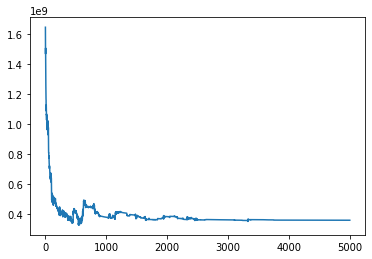

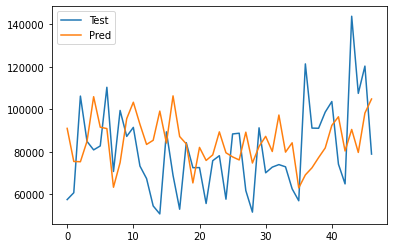

2022-04-30 20:46:31.351474: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model/num_txn/all/assets


In [6]:
n_steps_choices = [5,7,14,30]
# n_steps_choices = [14]
dataset = df['TOTAL_AMOUNT'].resample('1D').count()

train,test = train_test_split(dataset)
best_config = 14
best_score = 14
for steps in n_steps_choices:
    try:
        train_x, train_y = split_sequence(np.array(train), steps)
        # Train
        model = Sequential()
        model.add(LSTM(100, activation='relu', input_shape=(steps, 1),return_sequences=True))
        model.add(LSTM(100, activation='relu', input_shape=(steps, 1)))
        model.add(Dense(1))
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(
                                                    0.0001,
                                            decay_steps=50,
                                            decay_rate=0.96,
                                            staircase=True)
        optimizer =keras.optimizers.Adam(learning_rate=lr_schedule)
        lr_metric = get_lr_metric(optimizer)
        model.compile(optimizer=optimizer, loss='mse',metrics=[lr_metric])
        history = model.fit(train_x, train_y, epochs=5000, verbose=0)
        test_x, test_y = split_sequence(np.array(test), steps)
        pred = model.predict(test_x)
        test_error = np.sqrt(mean_squared_error(test_y,pred))
        if test_error < best_score:
            best_score = test_error
            best_config = steps
    except Exception as e:
        print("Exception",e)

print('Best Config', best_config)
steps = best_config
train_x, train_y = split_sequence(np.array(train), steps)
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(steps, 1),return_sequences=True))
model.add(LSTM(100, activation='relu', input_shape=(steps, 1)))
model.add(Dense(1))
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
                                                             0.0001,
                                            decay_steps=50,
                                            decay_rate=0.96,
                                            staircase=True)
optimizer =keras.optimizers.Adam(learning_rate=lr_schedule)
lr_metric = get_lr_metric(optimizer)
model.compile(optimizer=optimizer, loss='mse',metrics=[])
history = model.fit(train_x, train_y, epochs=5000, verbose=1)

fig, ax1 = plt.subplots()
ax1.plot(history.history['loss'])
# ax2 =  ax1.twinx()
# ax2.plot(history.history['lr'])
plt.show()
test_x, test_y = split_sequence(np.array(test), steps)
pred = model.predict(test_x)
plt.plot(range(len(test_y)),test_y,label='Test')
plt.plot(range(len(pred)),pred,label='Pred')
plt.legend()
plt.show()
model.save(f'model/num_txn/all')

In [ ]:
dataset = df['TOTAL_AMOUNT'].resample('1D').count()

train,test = train_test_split(dataset)
best_config = 0
best_score = 999999
# for steps in n_steps_choices:
#     try:
train_x, train_y = split_sequence(np.array(train), 7)
# Train
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(7, 1)))
model.add(Dense(1))
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
                                            0.001,
                                            decay_steps=400,
                                            decay_rate=0.98,
                                            staircase=True)
optimizer =keras.optimizers.Adam(learning_rate=lr_schedule)
lr_metric = get_lr_metric(optimizer)
model.compile(optimizer=optimizer, loss='mse',metrics=[lr_metric])
history = model.fit(train_x, train_y, epochs=10000, verbose=0)
# test_x, test_y = split_sequence(np.array(test), steps)
# pred = model.predict(test_x)
# test_error = np.sqrt(mean_squared_error(test_y,pred))
#         if test_error < best_score:
#             best_score = test_error
#             best_config = steps
#     except Exception as e:
#         print("Exception",e)

# print('Best Config', best_config)
# steps = best_config
# train_x, train_y = split_sequence(np.array(train), steps)
# model = Sequential()
# model.add(LSTM(50, activation='relu', input_shape=(steps, 1)))
# model.add(Dense(1))
# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#                                                             0.00001,
#                                                             decay_steps=100,
#                                                             decay_rate=0.96,
#                                                             staircase=True)
# optimizer =keras.optimizers.Adam(learning_rate=lr_schedule)
# lr_metric = get_lr_metric(optimizer)
# model.compile(optimizer=optimizer, loss='mse',metrics=[lr_metric])
# history = model.fit(train_x, train_y, epochs=10000, verbose=0)

fig, ax1 = plt.subplots()
ax1.plot(history.history['loss'])
ax2 =  ax1.twinx()
ax2.plot(history.history['lr'])
plt.show()
test_x, test_y = split_sequence(np.array(test), 7)
pred = model.predict(test_x)
plt.plot(range(len(test_y)),test_y,label='Test')
plt.plot(range(len(pred)),pred,label='Pred')
plt.legend()
plt.show()
# model.save(f'model/sum_txn/all')

In [ ]:
test_x, test_y = split_sequence(np.array(test), 7)
pred = model.predict(test_x)
plt.plot(range(len(test_y)),test_y,label='Test')
plt.plot(range(len(pred)),pred,label='Pred')
plt.legend()
plt.show()

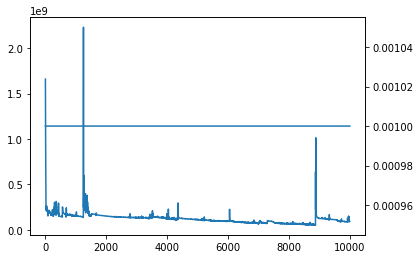

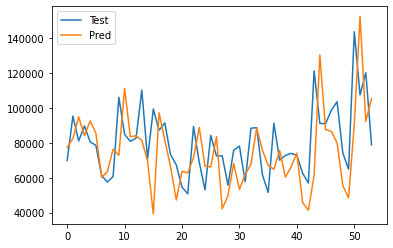

In [13]:
dataset = df['TOTAL_AMOUNT'].resample('1D').count()

train,test = train_test_split(dataset)
best_config = 0
best_score = 999999
# for steps in n_steps_choices:
#     try:
train_x, train_y = split_sequence(np.array(train), 7)
# Train
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(7, 1)))
model.add(Dense(1))
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
                                            0.001,
                                            decay_steps=400,
                                            decay_rate=0.98,
                                            staircase=True)
optimizer =keras.optimizers.Adam()
lr_metric = get_lr_metric(optimizer)
model.compile(optimizer=optimizer, loss='mse',metrics=[lr_metric])
history = model.fit(train_x, train_y, epochs=10000, verbose=0)
# test_x, test_y = split_sequence(np.array(test), steps)
# pred = model.predict(test_x)
# test_error = np.sqrt(mean_squared_error(test_y,pred))
#         if test_error < best_score:
#             best_score = test_error
#             best_config = steps
#     except Exception as e:
#         print("Exception",e)

# print('Best Config', best_config)
# steps = best_config
# train_x, train_y = split_sequence(np.array(train), steps)
# model = Sequential()
# model.add(LSTM(50, activation='relu', input_shape=(steps, 1)))
# model.add(Dense(1))
# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#                                                             0.00001,
#                                                             decay_steps=100,
#                                                             decay_rate=0.96,
#                                                             staircase=True)
# optimizer =keras.optimizers.Adam(learning_rate=lr_schedule)
# lr_metric = get_lr_metric(optimizer)
# model.compile(optimizer=optimizer, loss='mse',metrics=[lr_metric])
# history = model.fit(train_x, train_y, epochs=10000, verbose=0)

fig, ax1 = plt.subplots()
ax1.plot(history.history['loss'])
ax2 =  ax1.twinx()
ax2.plot(history.history['lr'])
plt.show()
test_x, test_y = split_sequence(np.array(test), 7)
pred = model.predict(test_x)
plt.plot(range(len(test_y)),test_y,label='Test')
plt.plot(range(len(pred)),pred,label='Pred')
plt.legend()
plt.show()
# model.save(f'model/sum_txn/all')

In [17]:
test_x

array([[[ 45665],
        [ 80724],
        [ 71216],
        [ 72988],
        [ 85789],
        [ 94365],
        [ 89251],
        [ 69857],
        [ 95421],
        [ 81086],
        [ 89749],
        [ 80616],
        [ 78539],
        [ 61246]],

       [[ 80724],
        [ 71216],
        [ 72988],
        [ 85789],
        [ 94365],
        [ 89251],
        [ 69857],
        [ 95421],
        [ 81086],
        [ 89749],
        [ 80616],
        [ 78539],
        [ 61246],
        [ 57509]],

       [[ 71216],
        [ 72988],
        [ 85789],
        [ 94365],
        [ 89251],
        [ 69857],
        [ 95421],
        [ 81086],
        [ 89749],
        [ 80616],
        [ 78539],
        [ 61246],
        [ 57509],
        [ 60731]],

       [[ 72988],
        [ 85789],
        [ 94365],
        [ 89251],
        [ 69857],
        [ 95421],
        [ 81086],
        [ 89749],
        [ 80616],
        [ 78539],
        [ 61246],
        [ 57509],
        [ 60731],
    